# Homework 2 - End to End Classification on Titanic Data

Imports

In [100]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
# inline plot
% matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
% config Completer.use_jedi = False

UsageError: Line magic function `%` not found.


In [101]:
from pathlib import Path
from typing import Tuple

#### Read the Data

In [102]:
data_dir_path = Path('..') / 'data'
train_df: pd.DataFrame = pq.read_table(data_dir_path / 'train.parquet', memory_map=True).to_pandas()
test_df: pd.DataFrame = pq.read_table(data_dir_path / 'test.parquet', memory_map=True).to_pandas()

#### First Impressions - basic analysis of the data

Some basic statistics on the data:

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [104]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Right away, we can see that the training set has information about 891 passengers, of which $\approx 38.4\%$ survived (and respectively, $\approx 61.6\%$ did not).

We can clearly spot, with a naked eye, that:
* The `Age` column has only $714 < 891$ entries.
* The `Cabin` column has $204 < 891$ entries.
* The `Embarked` column has $889 < 891$ entries.

which means there's some missing data right there.
It should be noted that the (non-missing) `Age` values are between 0.4 years (4.8 months) and 80 years, which is pretty diverse.

These conclusions can be verified:

In [105]:
total = train_df.isnull().sum().sort_values(ascending=False)
percentage = total / 891
missing_data = pd.concat([total, percentage], axis=1, keys=['Total Missing Entries', '% of Missing Entries'])
missing_data[missing_data['Total Missing Entries'] > 0]

,Total Missing Entries,% of Missing Entries
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


At this stage, the `Cabin` column might be a good candidate to drop, as it has more than $77\%$ of missing data.

### Contributions of different features

Now, let us investigate statistically (and graphically) the contributions of different features on survival:

#### Age and Sex

/opt/miniconda3/envs/orly_hw/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


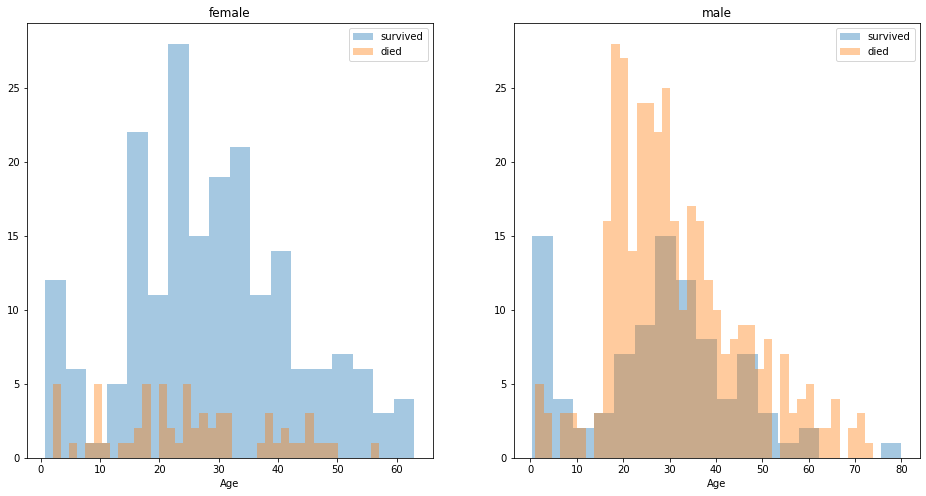

In [106]:
survived = 'survived'
died = 'died'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']

ax = sns.distplot(women[women['Survived'] == 1].Age.dropna(), bins=18, label=survived, ax=axes[0], kde=False)
ax = sns.distplot(women[women['Survived'] == 0].Age.dropna(), bins=40, label=died, ax=axes[0], kde=False)
ax.legend()
ax.set_title('female')

ax = sns.distplot(men[men['Survived'] == 1].Age.dropna(), bins=18, label=survived, ax=axes[1], kde=False)
ax = sns.distplot(men[men['Survived'] == 0].Age.dropna(), bins=40, label=died, ax=axes[1], kde=False)
ax.legend()
ax.set_title('male')

There seems to be some correlation between age groups for female/male subjects.

#### Embarked, Pclass (Passenger Class) and Sex:

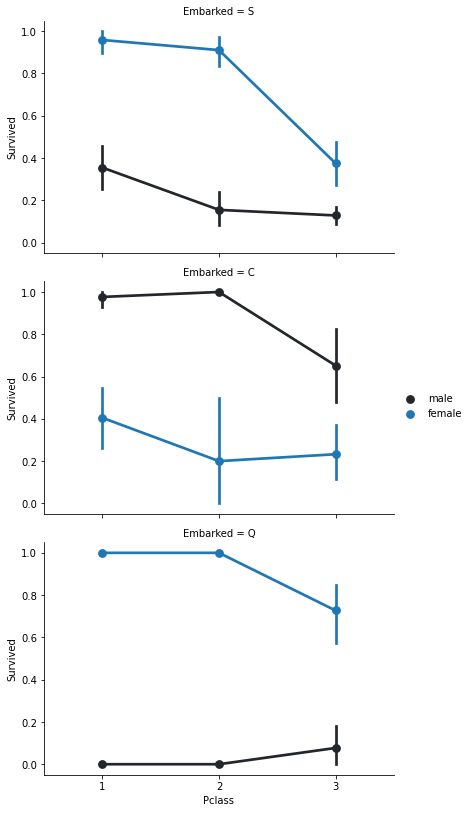

In [107]:
FacetGrid = sns.FacetGrid(data=train_df, row='Embarked', height=3.8, aspect=1.5)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None)
FacetGrid.add_legend()

We can see that women from the $1^{st}$ and $2^{nd}$ passenger classes have higher rates of survival than men when embarking on the Titanic in Southampton and Queenstown,
but men have higher rates of survival than women when embarking the Titanic in Cherbourg.

#### Pclass (Passenger Class)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

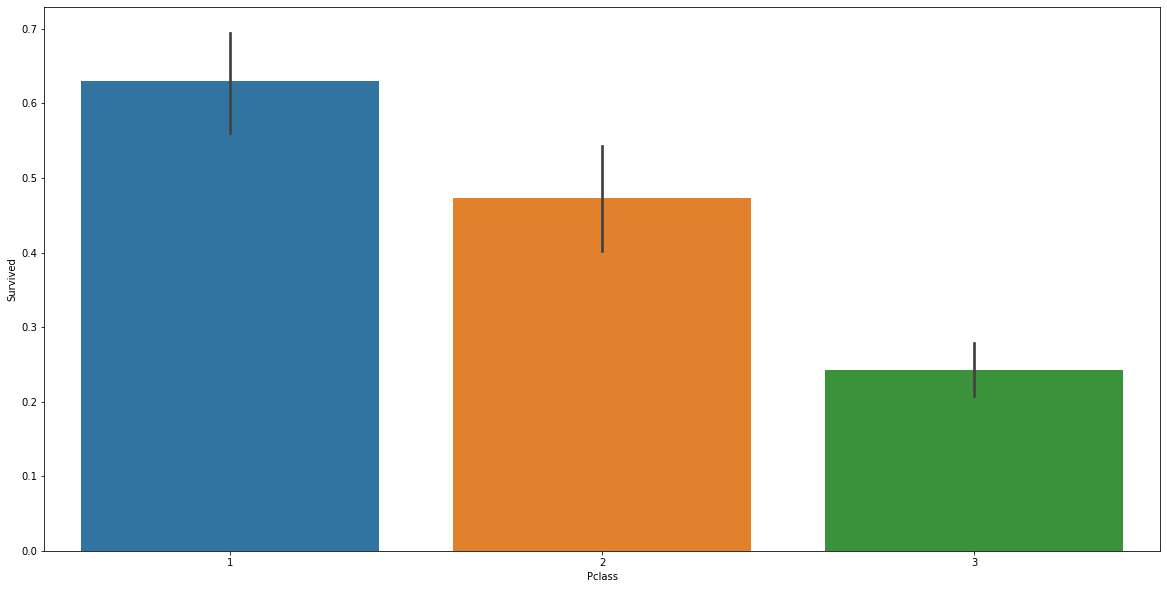

In [108]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

This corroborates our suspicion, that the higher the class $1^{st} > 2^{nd} > 3^{rd}$ $\Rightarrow$ the higher are the chances of survival.

#### SibSp and Parch:

Let us analyze the contributions of `SibSp` and `Parch`, separately and combined, since it might be more logical to look at their combined correlation to survival:

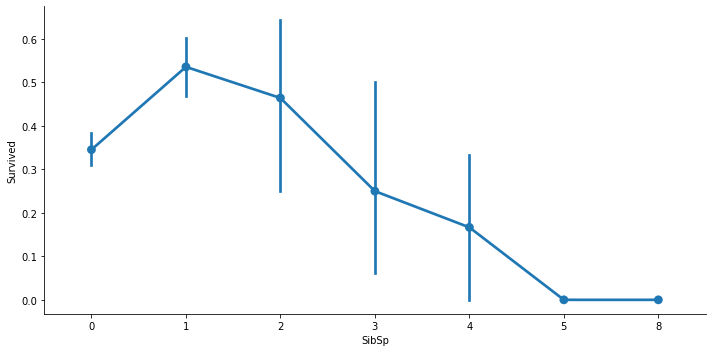

In [109]:
sns.catplot(data=train_df, x='SibSp', y='Survived', aspect=2, kind='point')

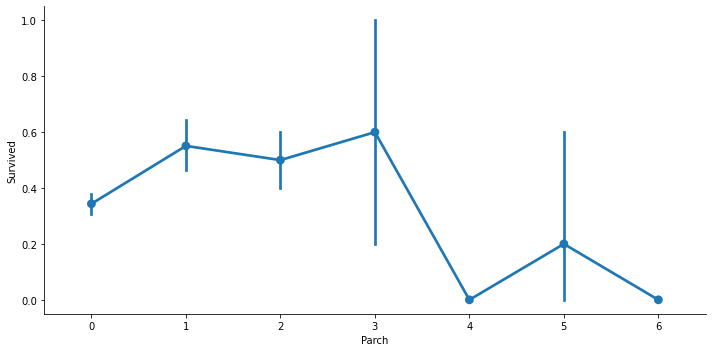

In [110]:
sns.catplot(data=train_df, x='Parch', y='Survived', aspect=2, kind='point')

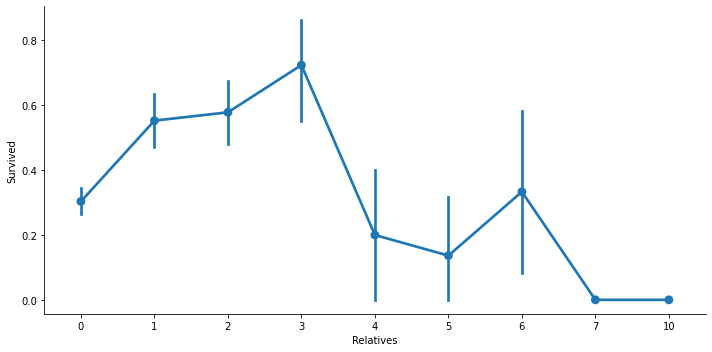

In [111]:
train_df['Relatives'] = train_df['SibSp'] + train_df['Parch']
sns.catplot(data=train_df, x='Relatives', y='Survived', aspect=2, kind='point')

Indeed, we see that passengers with 1-3 relatives (in total, siblings, spouses, children and parents) on-board have much higher sirvival rates.

### Feature Engineering

First, let us clean the data from non-relevant `PassengerId` and `Ticket` columns:

In [112]:
train_df.drop(columns=['PassengerId', 'Ticket'], inplace=True)

#### Missing Values

Let us look again at the missing values and their numbers:

In [113]:
missing_data[missing_data['Total Missing Entries'] > 0]

,Total Missing Entries,% of Missing Entries
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


##### Embarked

This collumn has only 2 missing values. Hence, it seems sufficient to replace its missing values with the most common departure port

In [114]:
most_common_embarked = train_df['Embarked'].mode()[0]
# fill the missing cells, in-place, with 'S', which is the common value
train_df['Embarked'].fillna(most_common_embarked, inplace=True)

##### Age

This column has $\approx 20\%$ of its entries missing. Probably, the best way to counter it is by setting these missing values to the mean age. Or, even better, we can derive the mean and the std of the column, and then generate random normal data with it.

In [115]:
mean = train_df['Age'].mean()
std = train_df['Age'].std()
# random normal generator for ages missing values
num_of_missing_ages = train_df['Age'].isnull().sum()
missing_ages = np.random.normal(mean, std, size=num_of_missing_ages).clip(min=0)
# fill the missing values
train_df['Age'].loc[train_df['Age'].isnull()] = missing_ages

/opt/miniconda3/envs/orly_hw/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now, we do not want to leave the `Age` column as a float column. It might be better to convert ages to groups of age ranges.
The logic here was finding a partition of approximately equal-sized groups.

In [171]:
train_df['Age_Groups'] = pd.cut(train_df['Age'], bins=[0, 17, 22, 28, 35, 48, 80], labels=list(range(6)))
train_df['Age_Groups'].value_counts()

3    175
4    174
2    159
0    147
1    136
5     95
Name: Age_Groups, dtype: int64

##### Embarked

Let us turn this categorical column to numerical values.

In [170]:
train_df['Embarked_Numerical'] = pd.factorize(train_df['Embarked'])[0]
train_df['Embarked_Numerical'].value_counts()

0    646
1    168
2     77
Name: Embarked_Numerical, dtype: int64